In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from src import data

from netneurotools import metrics
    # https://netneurotools.readthedocs.io/en/latest/, pip install netneurotools does not work for me
    # I downloaded the repository and I am using the local copy

%matplotlib widget

!date -I

2024-03-27


## Settings

In [5]:
FC_AVAILABLE = False # changed automatically if FC loaded

datasets_parcellations = {"enigma":["DKT"],
                          "domhof":["DKT","Destrieux","Schaffer"],
                          "rosen_halgren":["MNI-HCP-MMP1"]} # MNI-HCP-MMP1 is another name for Glasser parcellation

# set wehich dataset (and parecallation) to use for structural (and functional, if availible) connectivity
# availible datasets and parcellations listed above
STRUCTURAL_DATASET = "rosen_halgren" 
PARCELLATION =  "MNI-HCP-MMP1" 
AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK = False


if STRUCTURAL_DATASET not in datasets_parcellations.keys():
    print("Invalid dataset selection!")
elif PARCELLATION not in datasets_parcellations[STRUCTURAL_DATASET]:
    print(f"Selected dataset {STRUCTURAL_DATASET} not provided in {PARCELLATION} parcellation!")
    PARCELLATION == datasets_parcellations[STRUCTURAL_DATASET][0]
    print(f"Parcellation set to {PARCELLATION}")
else: 
    print(f"Selected dataset {STRUCTURAL_DATASET} and parcellation {PARCELLATION}.")

Selected dataset rosen_halgren and parcellation MNI-HCP-MMP1.


## Load data

### Load F-TRACT data

In [6]:
# F-TRACT dataset is availible in several parcellations, select and load the one defined above
response_probability, response_amplitude, n_stim, n_impl, ftract_labels = data.load_ftract(PARCELLATION)

if STRUCTURAL_DATASET == "enigma":
    # following ROIs are not present in enigma with DKT parcellation, so it should be deleted from responses to have matching dimensions
    ids_to_delete = [37,3] 
    
    for a in[0,1]:
        response_probability = np.delete(response_probability,ids_to_delete,axis=a)
        response_amplitude = np.delete(response_amplitude,ids_to_delete,axis=a)
        n_stim = np.delete(n_stim,ids_to_delete,axis=a)
        n_impl = np.delete(n_impl,ids_to_delete,axis=a)

mask = np.logical_and(n_stim > 100, n_impl > 5)

if AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK:
    mask_amp = mask
else:
    mask_amp = (n_stim*response_probability)>100 # 100 significant responses FIXME opravdu to takhle jde?

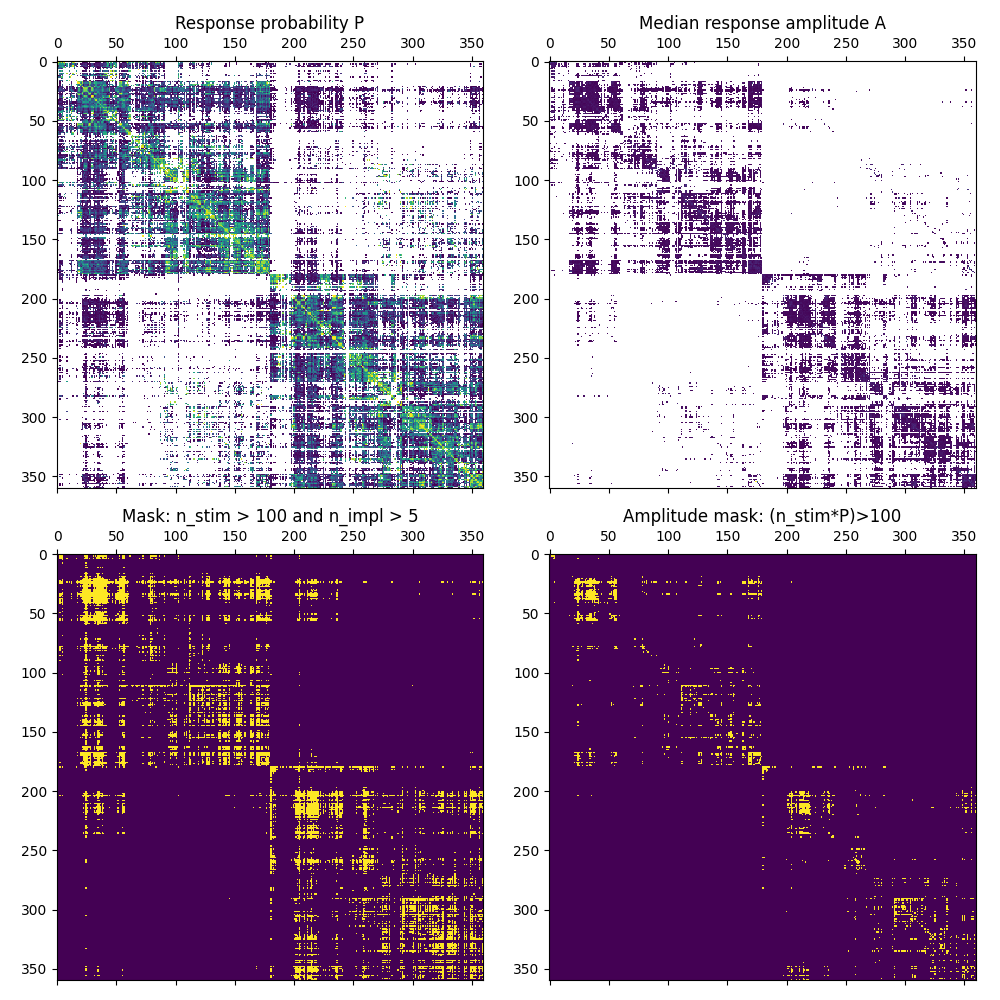

In [7]:
plt.rcParams['figure.figsize'] = [10, 10]

fig, axs = plt.subplots(2, 2, tight_layout=True)
axs[0,0].matshow(response_probability)
axs[0,0].set_title("Response probability P")
axs[0,1].matshow(response_amplitude)
axs[0,1].set_title("Median response amplitude A")
axs[1,0].matshow(mask)
axs[1,0].set_title("Mask: n_stim > 100 and n_impl > 5")
axs[1,1].matshow(mask_amp)

if AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK:
    axs[1,1].set_title("Amplitude mask same as mask")
else:
    axs[1,1].set_title("Amplitude mask: (n_stim*P)>100")

### Load structural (and functional) connectivity data

In [58]:
if STRUCTURAL_DATASET == "enigma":
    SC_W, SC_L, FC = data.load_enigma(ftract_labels)

elif STRUCTURAL_DATASET == "domhof":
    SC_W, SC_L, FC = data.load_domhof(PARCELLATION,len(ftract_labels))

elif STRUCTURAL_DATASET == "rosen_halgren":
    SC_W_log, SC_L, FC = data.load_rosen_halgren(ftract_labels)
    SC_W = 10 ** SC_W_log

if FC is not None:
    FC_AVAILABLE = True

print(SC_W.shape)

(360, 360)


/tmp/ipykernel_29264/3867738878.py:8: RuntimeWarning: divide by zero encountered in log
  axs[1].matshow(np.log(SC_L))


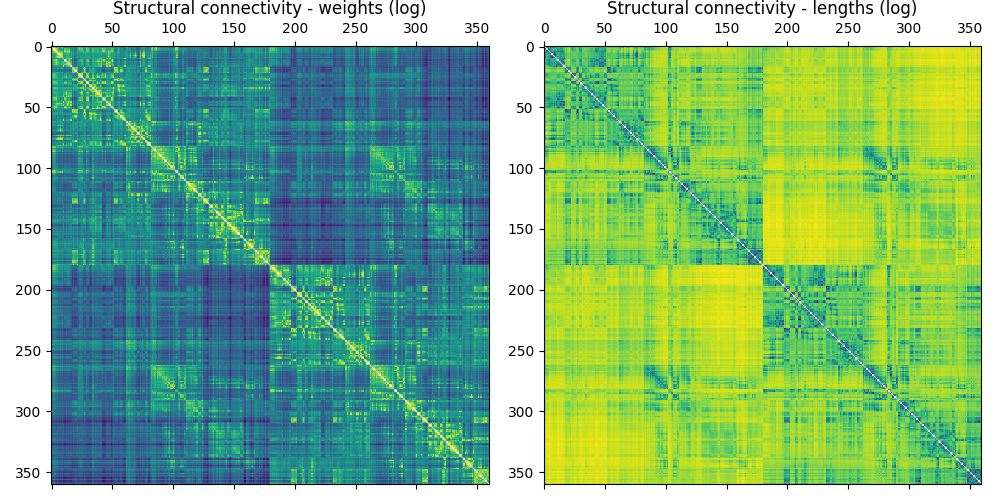

In [59]:
plt.rcParams['figure.figsize'] = [10, 5]

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].matshow(np.log(SC_W))
axs[0].set_title("Structural connectivity - weights (log)")

if SC_L is not None:
    axs[1].matshow(np.log(SC_L))
    axs[1].set_title("Structural connectivity - lengths (log)")

else:
    axs[1].matshow(np.zeros(SC_W.shape))
    axs[1].set_title("Structural connectivity - NO lengths")

Text(0.5, 1.0, 'ROI distances')

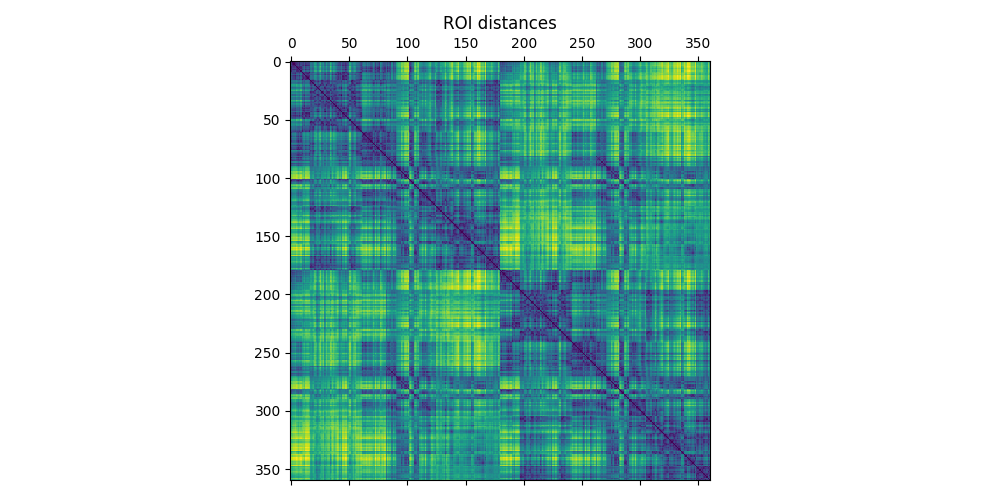

In [60]:
if PARCELLATION == "MNI-HCP-MMP1":
    ED = data.glasser_roi_distances(reference_labels=ftract_labels)
else:
    ED = SC_L

fig, axs = plt.subplots(1, 1, tight_layout=True)
axs.matshow(ED)
axs.set_title("ROI distances")

In [61]:
SC_W

array([[           nan, 1.33809456e-02, 1.42687058e-01, ...,
        1.06331491e-05, 7.36649885e-05, 2.28538247e-04],
       [1.33809456e-02,            nan, 1.96438742e-02, ...,
        6.69586342e-06, 3.19652566e-05, 1.43033072e-04],
       [1.42687058e-01, 1.96438742e-02,            nan, ...,
        7.65540532e-06, 5.11422361e-05, 1.65204254e-04],
       ...,
       [1.06331491e-05, 6.69586342e-06, 7.65540532e-06, ...,
                   nan, 1.76953008e-03, 1.76777717e-03],
       [7.36649885e-05, 3.19652566e-05, 5.11422361e-05, ...,
        1.76953008e-03,            nan, 2.78384776e-03],
       [2.28538247e-04, 1.43033072e-04, 1.65204254e-04, ...,
        1.76777717e-03, 2.78384776e-03,            nan]])

In [62]:
np.fill_diagonal(SC_W,0)
np.fill_diagonal(SC_L,0)

## Correlations

In [63]:
df_probability = pd.DataFrame({"response_probability":response_probability[mask].flatten()})
df_amplitude = pd.DataFrame({"response_amplitude":response_amplitude[mask_amp].flatten()})

def fill_df(df,mask,ED,SC_L,SC_W):
    df["ED"] = ED[mask].flatten()
    df["SC_W"] = SC_W[mask].flatten()
    df["SC_W_log"] = SC_W_log[mask].flatten()

    if SC_L is not None:
        df["SC_L"] = SC_L[mask].flatten()
        shortest_paths,_ = metrics.distance_wei_floyd(SC_L)
        shortest_path_eff = np.divide(1,shortest_paths)
        df["shortest_path_eff"] = shortest_path_eff[mask].flatten()
    else:
        shortest_paths,_ = metrics.distance_wei_floyd(1/SC_W)
        shortest_path_eff = np.divide(1,shortest_paths)
        df["shortest_path_eff_W"] = shortest_path_eff[mask].flatten()

    com = metrics.communicability_wei(SC_W)
    df["communicability"] = com[mask].flatten()

    SI = metrics.search_information(SC_W,ED)
    df["search_information"] = SI[mask].flatten()

    _,_,nav_paths,_,_ = metrics.navigation_wu(ED, SC_W)
    nav_eff = np.divide(1,nav_paths)
    df["navigation_eff"] = nav_eff[mask].flatten()

    _, diff_eff = metrics.diffusion_efficiency(SC_W)
    df["diffusion_eff"] = diff_eff[mask].flatten()

    # nápady, které nikam nevedly
    # mfpt = metrics.mean_first_passage_time(SC_W)
    # df["MFPT"] = mfpt[mask].flatten()
    
    # df["communities"] = communities_matrix[mask].flatten()

fill_df(df_probability,mask,ED,SC_L,SC_W)
fill_df(df_amplitude,mask_amp,ED,SC_L,SC_W)

# ValueError: cannot convert float NaN to integer 
# proč to sakra zase nefunguje! protože je to znormalizované a v té matici jsou záporná čísla...

df_probability

/tmp/ipykernel_29264/119882493.py:12: RuntimeWarning: divide by zero encountered in divide
  shortest_path_eff = np.divide(1,shortest_paths)
/tmp/ipykernel_29264/119882493.py:26: RuntimeWarning: divide by zero encountered in divide
  nav_eff = np.divide(1,nav_paths)
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:780: RuntimeWarning: divide by zero encountered in divide
  E_diff = np.divide(1, mfpt)
/tmp/ipykernel_29264/119882493.py:12: RuntimeWarning: divide by zero encountered in divide
  shortest_path_eff = np.divide(1,shortest_paths)
/tmp/ipykernel_29264/119882493.py:26: RuntimeWarning: divide by zero encountered in divide
  nav_eff = np.divide(1,nav_paths)
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:780: RuntimeWarning: divide by zero encountered in divide
  E_diff = np.divide(1, mfpt)


,response_probability,ED,SC_W,SC_W_log,SC_L,shortest_path_eff,communicability,search_information,navigation_eff,diffusion_eff
0,0.610,0.000000,0.000000,NaN,0.000000,inf,0.000000,NaN,inf,0.000000
1,0.665,26.298164,0.013381,-1.873513,66.755976,0.014980,0.043158,5.596135,0.038025,0.002282
2,0.502,2.504706,0.142687,-0.845615,18.899487,0.052911,0.239334,2.181532,0.399248,0.004823
3,0.342,7.495208,0.062711,-1.202659,36.320113,0.027533,0.128061,3.367606,0.133419,0.003931
4,0.559,17.947822,0.019655,-1.706527,58.410091,0.017120,0.051246,5.041419,0.055717,0.003455
...,...,...,...,...,...,...,...,...,...,...
10330,0.707,21.974862,0.001923,-2.716047,90.149458,0.011851,0.012359,7.938064,0.045507,0.002291
10331,0.174,40.033325,0.001129,-2.947340,115.252627,0.008677,0.005732,8.706404,0.024979,0.002975
10332,0.563,24.863722,0.000529,-3.276195,132.158012,0.008393,0.004998,9.798836,0.040219,0.002739
10333,0.586,22.030741,0.000498,-3.302417,152.712822,0.006784,0.002852,9.885946,0.045391,0.002894


In [64]:
pg.pairwise_corr(df_probability,columns=["response_probability"], method='spearman').round(3)

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,response_probability,ED,spearman,two-sided,10335,-0.759,"[-0.77, -0.75]",0.0,1.0
1,response_probability,SC_W,spearman,two-sided,10335,0.463,"[0.45, 0.48]",0.0,1.0
2,response_probability,SC_W_log,spearman,two-sided,10187,0.522,"[0.51, 0.54]",0.0,1.0
3,response_probability,SC_L,spearman,two-sided,10335,-0.670,"[-0.68, -0.66]",0.0,1.0
4,response_probability,shortest_path_eff,spearman,two-sided,10335,0.694,"[0.68, 0.7]",0.0,1.0
5,response_probability,communicability,spearman,two-sided,10335,0.535,"[0.52, 0.55]",0.0,1.0
6,response_probability,search_information,spearman,two-sided,10187,-0.531,"[-0.54, -0.52]",0.0,1.0
7,response_probability,navigation_eff,spearman,two-sided,10335,0.759,"[0.75, 0.77]",0.0,1.0
8,response_probability,diffusion_eff,spearman,two-sided,10335,0.100,"[0.08, 0.12]",0.0,1.0


In [68]:
pg.partial_corr(df_probability, x='response_probability', y='shortest_path_eff', covar='ED',method="spearman").round(3) # tohle mi nevychází tak úplně stejně jako F-Tract?

,n,r,CI95%,p-val
spearman,10335,0.251,"[0.23, 0.27]",0.0


In [66]:
pg.pairwise_corr(df_amplitude,columns=["response_amplitude"], method='spearman').round(3)

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,response_amplitude,ED,spearman,two-sided,2319,-0.655,"[-0.68, -0.63]",0.000,1.00
1,response_amplitude,SC_W,spearman,two-sided,2319,0.328,"[0.29, 0.36]",0.000,1.00
2,response_amplitude,SC_W_log,spearman,two-sided,2189,0.510,"[0.48, 0.54]",0.000,1.00
3,response_amplitude,SC_L,spearman,two-sided,2319,-0.641,"[-0.66, -0.62]",0.000,1.00
4,response_amplitude,shortest_path_eff,spearman,two-sided,2319,0.645,"[0.62, 0.67]",0.000,1.00
5,response_amplitude,communicability,spearman,two-sided,2319,0.345,"[0.31, 0.38]",0.000,1.00
6,response_amplitude,search_information,spearman,two-sided,2189,-0.517,"[-0.55, -0.49]",0.000,1.00
7,response_amplitude,navigation_eff,spearman,two-sided,2319,0.655,"[0.63, 0.68]",0.000,1.00
8,response_amplitude,diffusion_eff,spearman,two-sided,2319,0.055,"[0.01, 0.1]",0.008,0.76
